# Geoacoustic Parameter Estimation using Bayesian Optimization with a Gaussian Process Surrogate Model

William Jenkins | Scripps Institution of Oceanography | wjenkins@ucsd.edu

In [1]:
from pathlib import Path
import sys

from ax.modelbridge.generation_strategy import GenerationStrategy, GenerationStep
from ax.modelbridge.registry import Models
from ax.plot.slice import plot_slice
from ax.service.ax_client import AxClient
from ax.utils.notebook.plotting import render
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm

sys.path.insert(0, '/Users/williamjenkins/Research/Code/TritonOA/')

from tritonoa.io import read_ssp
from tritonoa.kraken import KRAKENModelConfiguration, run_kraken
import tritonoa.plotting as plotting
from tritonoa.sp import ambiguity_function, normalize_pressure
from tritonoa.core import Top, Bottom, SoundSpeedProfile, Layer, Source, Receiver

## 1&nbsp;&nbsp;Simulate the Source

In this section, an acoustic pressure field is generated to simulate data that is recorded on an acoustic array.  These simulated data comprise the observed data to which replica data will be compared using the Bartlett processor.

### 1.1&nbsp;&nbsp;View TL given source depth over depth and range.

Before proceeding, let's look at what the transmission loss would look like for the given environment.

Text(0.5, 0.98, 'Source Depth = 54 m\nSource Freq = 148 Hz')

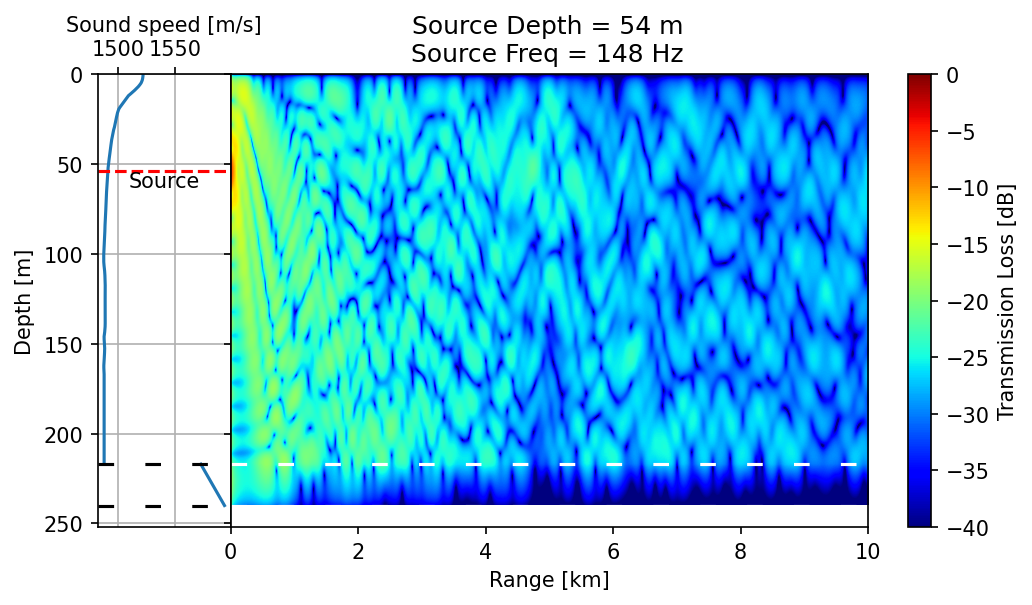

In [2]:
profile = "SWELLEX"
title = profile

fname = Path("/Users/williamjenkins/Research/Projects/BOGP/Data/ctds 2/i9606.prn")
z_data, c_data, _ = read_ssp(fname, 0, 3, header=None)
z_data = np.append(z_data, 217)
c_data = np.append(c_data, c_data[-1])

top = Top()

layerdata = [
    {
        "z": z_data,
        "c_p": c_data,
        "rho": 1
    },
    {
        "z": [217, 240],
        "c_p": [1572.37, 1593.02],
        "rho": 1.8,
        "a_p": 0.3
    },
    {
        "z": [240, 1040],
        "c_p": [1881, 3245.8],
        "rho": 2.1,
        "a_p": 0.09
    }
]

layers = [Layer(SoundSpeedProfile(**kwargs)) for kwargs in layerdata]

bottom = Bottom(opt="A", z=layers[-1].z_max+1, c_p=5200, rho=2.7, a_p=0.03)

source = Source(54)
zvec = np.arange(0, layers[1].z_max, 0.5)
dr = 0.5 * 1e-3
rvec = np.arange(0, 10 + dr, dr)
receiver = Receiver(zvec, rvec)

freq = 148
clow = 0
chigh = 1600

kmodel = KRAKENModelConfiguration(
    title,
    freq,
    layers,
    top,
    bottom,
    source,
    receiver,
    clow=clow,
    chigh=chigh,
    tmpdir="tmp"
)

model = "KRAKENC"
kmodel.run(fldflag=True, model=model)
p_rec = kmodel.modes.p
p_rec_norm = normalize_pressure(kmodel.modes.p, log=True)


fig, axs = plt.subplots(1, 2, sharey=True, gridspec_kw={"width_ratios": [1, 6], "wspace": 0}, figsize=(8, 4), dpi=150)

z = np.array([])
c = np.array([])
b = np.array([])
for layer in layers[:-1]:
    z = np.concatenate((z, layer.ssp.z))
    c = np.concatenate((c, layer.ssp.c_p))
    b = np.concatenate((b, [layer.z_max]))

ax = plotting.plot_SSP(
    z,
    c,
    boundaries=b,
    xlabel="Sound speed [m/s]",
    ylabel="Depth [m]",
    ax=axs[0]
)
ax.axhline(kmodel.source.z, c='r', linestyle='--')
ax.text(np.mean(ax.get_xlim()), kmodel.source.z.item(), f"Source", ha="center", va="top")

ax = plotting.plot_TL_2d(
    p_rec_norm,
    z=kmodel.receiver.z,
    r=np.concatenate((np.array([0]), kmodel.receiver.r)),
    boundaries=b,
    xlabel="Range [km]",
    clabel="Transmission Loss [dB]",
    vmin=-40,
    ax=axs[1]
)
fig.suptitle(f"Source Depth = {kmodel.source.z.item()} m\nSource Freq = {freq} Hz")
# fig.savefig("../../Reports/Figures/TL_SWELLEX_148Hz_54m_8km.png", dpi=300, facecolor="white", bbox_inches="tight")

### 1.2&nbsp;&nbsp;Set the parameters of the source.

Now that we have an understanding of what the acoustic propagation looks like for this environment, let's proceed with simulating the source.  First we will set source location and geoacoustic parameters of the environment.

In [3]:
depth_true = 54
range_true = 4.4

# ======================================================================
# ---------------------- Miscellaneous Parameters ----------------------
fixedparams = dict()
fixedparams["title"] = "SWELLEX96"
fixedparams["tmpdir"] = "tmp"
fixedparams["model"] = "KRAKENC"

# --------------------------- Top Parameters ---------------------------
# None to configure.

# -------------------------- Layer Parameters --------------------------
fixedparams["layerdata"] = [
    {
        "z": z_data,
        "c_p": c_data,
        "rho": 1
    },
    {
        "z": [217, 240],
        "c_p": [1572.37, 1593.02],
        "rho": 1.8,
        "a_p": 0.3
    },
    {
        "z": [240, 1040],
        "c_p": [1881, 3245.8],
        "rho": 2.1,
        "a_p": 0.09
    }
]

# ------------------------- Bottom Parameters --------------------------
# Note: By default, bottom depth is pulled from layer data
fixedparams["bot_opt"] = "A"
fixedparams["bot_c_p"] = 5200
fixedparams["bot_rho"] = 2.7
fixedparams["bot_a_p"] = 0.03

# ------------------------- Source Parameters --------------------------
fixedparams["src_z"] = depth_true

# ------------------------ Receiver Parameters ------------------------
fixedparams["rec_z"] = np.linspace(94.125, 212.25, 64)
fixedparams["rec_r"] = range_true


# ------------------------ Freq/Mode Parameters ------------------------
fixedparams["freq"] = freq
fixedparams["clow"] = 0
fixedparams["chigh"] = 1600

### 1.3&nbsp;&nbsp;Calculate received pressure field.

Using the environmental and localization parameters set above, we compute the received pressure field at the receiver array for the simulated source.

Text(0.5, 1.0, 'Imaginary Part')

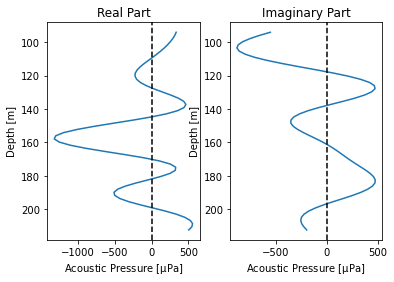

In [4]:
p_rec = run_kraken(fixedparams)

# Normalize pressure field
p_rec_norm = normalize_pressure(p_rec, log=True)

# Calculate covariance matrix
K = p_rec @ p_rec.conj().T

fig = plt.figure(figsize=(6, 4))

plt.subplot(1, 2, 1)
plt.plot(np.real(p_rec)*1e6, fixedparams["rec_z"])
plt.gca().invert_yaxis()
plt.axvline(0, c="k", linestyle="--")
plt.xlabel(r"Acoustic Pressure [$\mathrm{\mu}$Pa]")
plt.ylabel("Depth [m]")
plt.title("Real Part")

plt.subplot(1, 2, 2)
plt.plot(np.imag(p_rec)*1e6, fixedparams["rec_z"])
plt.gca().invert_yaxis()
plt.axvline(0, c="k", linestyle="--")
plt.xlabel(r"Acoustic Pressure [$\mathrm{\mu}$Pa]")
plt.ylabel("Depth [m]")
plt.title("Imaginary Part")

# fig.savefig("../../Reports/Figures/swellex_rx_pressure.png", dpi=300, facecolor="white", bbox_inches="tight")

## 2&nbsp;&nbsp;Optimization

In this section, we will attempt to localize the acoustic source and to estimate certain geoacoustic parameters which may be unknown.  Various methods are presented here, including grid search (matched field processing, or MFP), Bayesian optimization using a Gaussian process surrogate model (BOGP), and others.  A simple 2-D case is presented as a tutorial to demonstrate the BOGP method.

### 2.1&nbsp;&nbsp;Define search space

The first step is to define the parameter search space.  The source localization and geoacoustic parameters are split into two dictionaries: one for those parameters which are known and therefore fixed; and a second for those parameters which we seek to estimate.  These searchable parameters as ranges which will be sampled in the course of the various methods presented.

In the case of 2-D localization, the only search parameters are the source range and depth.

In [5]:
# ======================================================================
# ========================== FIXED PARAMETERS ==========================
# ======================================================================

# ---------------------- Miscellaneous Parameters ----------------------
fixedparams = dict()
fixedparams["title"] = "SWELLEX96"
fixedparams["tmpdir"] = "tmp"
fixedparams["model"] = "KRAKENC"

# --------------------------- Top Parameters ---------------------------
# None to configure.

# -------------------------- Layer Parameters --------------------------
fixedparams["layerdata"] = [
    {
        "z": z_data,
        "c_p": c_data,
        "rho": 1
    },
    {
        "z": [217, 240],
        "c_p": [1572.37, 1593.02],
        "rho": 1.8,
        "a_p": 0.3
    },
    {
        "z": [240, 1040],
        "c_p": [1881, 3245.8],
        "rho": 2.1,
        "a_p": 0.09
    }
]

# ------------------------- Bottom Parameters --------------------------
# Note: By default, bottom depth is pulled from layer data
fixedparams["bot_opt"] = "A"
fixedparams["bot_c_p"] = 5200.
fixedparams["bot_rho"] = 2.7
fixedparams["bot_a_p"] = 0.03

# ------------------------- Source Parameters --------------------------
fixedparams["src_z"] = depth_true

# ------------------------ Receiver Parameters ------------------------
fixedparams["rec_z"] = np.linspace(94.125, 212.25, 64)
# fixedparams["rec_r"] = range_true


# ------------------------ Freq/Mode Parameters ------------------------
fixedparams["freq"] = freq
fixedparams["clow"] = 0
fixedparams["chigh"] = 1600


# ======================================================================
# ============================ SEARCH SPACE ============================
# ======================================================================
parameters = [
    {
        "name": "rec_r",
        "type": "range",
        "bounds": [3.0, 6.0],
        "value_type": "float"
    },
    # {
    #     "name": "src_z",
    #     "type": "range",
    #     "bounds": [10., 100.],
    #     "value_type": "float"
    # }
]

### 2.2&nbsp;&nbsp;Matched Field Processing

In [6]:
dr = 5 / 1e3
rvec = np.arange(3., 6. + dr, dr)
zvec = np.arange(1., 211., 1)

pbar = tqdm(
    zvec,
    bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}',
    desc="MFP",
    leave=True,
    position=0,
    unit=" step"
)

p_rep = np.zeros((len(zvec), len(rvec), len(fixedparams["rec_z"])))
B_bart = np.zeros((len(zvec), len(rvec)))
# B_mvdr = np.zeros((len(zvec), len(rvec)))
for zz, z in enumerate(pbar):
    p_rep = run_kraken(fixedparams | {"src_z": z, "rec_r": rvec})    
    for rr, r in enumerate(rvec):
        B_bart[zz, rr] = ambiguity_function(K, p_rep[:, rr], atype="bartlett").item()
        # B_mvdr[zz, rr] = ambiguity_function(K, p_rep[:, rr], atype="MVDR").item()

MFP: 100%|████████████████████| 210/210 [00:11<00:00, 18.03 step/s]


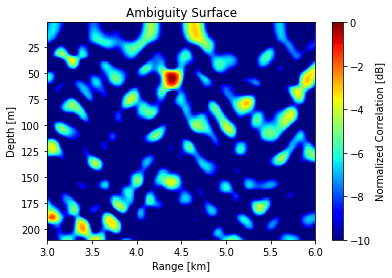

In [7]:
Bn = B_bart / np.max(B_bart)
logBn = 10 * np.log10(Bn)
src_z_ind, src_r_ind = np.unravel_index(np.argmax(logBn), (len(zvec), len(rvec)))

fig = plt.figure(figsize=(6, 4))
plt.imshow(
    logBn,
    aspect="auto",
    extent=[min(rvec), max(rvec), min(zvec), max(zvec)],
    origin="lower",
    vmin=-10, vmax=0, interpolation="none",
    cmap="jet"
)
# plt.plot(rvec[src_r_ind], zvec[src_z_ind], 'w*', markersize=15, markeredgewidth=1.5, markeredgecolor="k")
plt.gca().invert_yaxis()
plt.xlabel("Range [km]")
plt.ylabel("Depth [m]")
plt.title("Ambiguity Surface")
plt.colorbar(label="Normalized Correlation [dB]")
plt.show()

# fig.savefig("../../Reports/Figures/MFP_SWELLEX.png", dpi=300, facecolor="white", bbox_inches="tight")
# fig.savefig("../../Reports/Figures/MFP_SWELLEX_nolocation.png", dpi=300, facecolor="white", bbox_inches="tight")

# Bn = B_mvdr / np.max(B_mvdr)
# logBn = 10 * np.log10(Bn)
# src_z_ind, src_r_ind = np.unravel_index(np.argmax(logBn), (len(zvec), len(rvec)))
# plt.imshow(
#     logBn,
#     aspect="auto",
#     extent=[min(rvec), max(rvec), min(zvec), max(zvec)],
#     origin="lower",
#     vmin=-200, vmax=0, interpolation="none")
# plt.plot(rvec[src_r_ind], zvec[src_z_ind], 'r*')
# plt.gca().invert_yaxis()
# plt.title("MVDR")
# plt.colorbar()
# plt.show()
# print(src_z_ind, src_r_ind)

In [ ]:
fig = plt.figure(figsize=(6, 4))
plt.plot(rvec, Bn[src_z_ind])
plt.xlabel("Range [km]")
plt.ylabel("Normalized Correlation")
plt.title(fr"Ambiguity Surface at $z={zvec[src_z_ind]}$ m")
# fig.savefig("../../Reports/Figures/1D_amb_surf.png", dpi=300, facecolor="white", bbox_inches="tight")

In [ ]:
fig = plt.figure(figsize=(6, 4))
plt.plot(rvec, Bn[src_z_ind], label="True Function", zorder=1)
np.random.seed(3)
idx = np.random.randint(0, len(rvec), 20)
plt.scatter(rvec[idx], Bn[src_z_ind, idx], c="k", s=50, marker="+", label="Samples", zorder=2)
plt.ylim(0, 1)
plt.xlabel("Range [km]")
plt.ylabel("Normalized Correlation")
plt.legend()
# fig.savefig("../../Reports/Figures/1D_amb_surf_rand.png", dpi=300, facecolor="white", bbox_inches="tight")

In [ ]:
fig = plt.figure(figsize=(6, 4))
plt.plot(rvec, Bn[src_z_ind], label="True Function", zorder=1)
idx1 = np.arange(-7, 7) + 154
idx2 = np.array([100, 303, 315, 400, 500, 550])

idx = np.concatenate((idx1, idx2))
plt.scatter(rvec[idx], Bn[src_z_ind, idx], c="k", s=50, marker="+", label="Samples", zorder=2)
plt.ylim(0, 1)
plt.xlabel("Range [km]")
plt.ylabel("Normalized Correlation")
plt.legend()
# fig.savefig("../../Reports/Figures/1D_amb_surf_seqdemo.png", dpi=300, facecolor="white", bbox_inches="tight")

In [ ]:
from numpy.random import randint
from sklearn.preprocessing import MinMaxScaler

fig = plt.figure(figsize=(6, 4))
np.random.seed(2009)
fsum = 0
for i in range(3):
    f = randint(1,100)*np.sin(randint(0,100) * rvec / rvec.max()) + randint(1,100)*np.cos(randint(0,100) * rvec / rvec.max())
    f = MinMaxScaler(feature_range=(0.05, 0.95)).fit_transform(f.reshape(-1, 1)).reshape(-1)
    plt.plot(rvec, f)
    fsum += f


plt.plot(rvec, fsum/3, "k--")
plt.axhline(0.5, c="k", linestyle="--")
plt.fill_between(rvec, 0.1 * np.ones_like(rvec), 0.9 * np.ones_like(rvec), alpha=0.2)
plt.xlim(rvec.min(), rvec.max())
# plt.ylim(0, 1)
plt.xlabel("Range [km]")
plt.ylabel("Normalized Correlation")
plt.title(fr"Functions drawn at random")
# fig.savefig("../../Reports/Figures/1D_rand_draws.png", dpi=300, facecolor="white", bbox_inches="tight")



In [ ]:
import scipy.stats as stats

np.random.seed(2018)
x = np.arange(1, 101, 1)
print(x.min())
mu = randint(1, 100)*np.sin(randint(0, 100) * x / x.max()) + randint(1, 100)*np.cos(randint(0, 100) * x / x.max())
mu = MinMaxScaler(feature_range=(-1, 1)).fit_transform(mu.reshape(-1, 1)).reshape(-1)

sigma = (5 * np.sin(2 * np.pi * x / x.max()) + 10 * x / x.max()) / 5
variance = np.sqrt(sigma)


fig = plt.figure(figsize=(4, 3), dpi=300)
plt.plot(mu, "k--", label="$\mu$")
plt.plot(mu - 2*sigma, "k", label="$\mu \pm 2\sigma$")
plt.plot(mu + 2*sigma, "k", label=None)
plt.fill_between(x, mu - 2*sigma, mu + 2*sigma, alpha=0.2, label=None)
plt.xlim(x.min(), x.max())
xi = [22, 55, 75]
[plt.axvline(i, c="k", linestyle=":") for i in xi]
plt.ylim(-4, 4)
plt.xticks(xi, [f"$x_{i+1}$" for i in range(len(xi))])
plt.xlabel("$\mathbf{x}=[x_1, x_2, \dots, x_n]$")
plt.ylabel("$f(\mathbf{x})$", rotation=0)
plt.tight_layout()
plt.legend(loc="upper right", framealpha=0.95)
plt.show()


fig = plt.figure(figsize=(9, 2), dpi=300)

for i, xi in enumerate(xi):
    m = mu[xi]
    s = sigma[xi]
    x = np.linspace(m - 3*s, m + 3*s, 101)
    f = stats.norm.pdf(x, m, s)
    plt.subplot(1, 3, i+1)
    plt.fill_between(x, 0, f, alpha=0.2, label=None)
    plt.plot([m, m], [0, f.max()], "k--", label="$\mu$")
    plt.plot([m + 2*s, m + 2*s], [0, stats.norm.pdf(m + 2*s, m, s)], "k", label="$\mu \pm 2\sigma$")
    plt.plot([m - 2*s, m - 2*s], [0, stats.norm.pdf(m - 2*s, m, s)], "k", label=None)


    plt.xlim(-4, 4)
    plt.ylim(0, 1)
    plt.xlabel(f"$x_{i+1}$")
    plt.ylabel(f"$f(x_{i+1})$", rotation=0, ha="right")
    if i == 0:
        plt.legend(loc="upper left", framealpha=0.95)

plt.tight_layout()

### Perform Bayesian optimization w/ Gaussian process

/Users/williamjenkins/miniconda3/envs/gp/lib/python3.9/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning:

Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.

/Users/williamjenkins/miniconda3/envs/gp/lib/python3.9/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning:

Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.



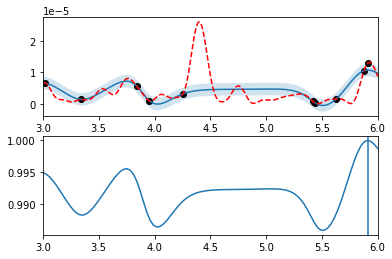

/Users/williamjenkins/miniconda3/envs/gp/lib/python3.9/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning:

Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.

/Users/williamjenkins/miniconda3/envs/gp/lib/python3.9/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning:

Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.



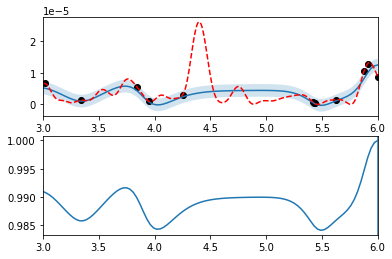

/Users/williamjenkins/miniconda3/envs/gp/lib/python3.9/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning:

Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.

/Users/williamjenkins/miniconda3/envs/gp/lib/python3.9/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning:

Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.



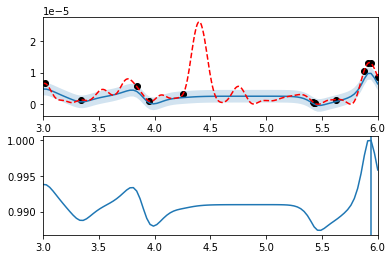

/Users/williamjenkins/miniconda3/envs/gp/lib/python3.9/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning:

Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.

/Users/williamjenkins/miniconda3/envs/gp/lib/python3.9/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning:

Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.



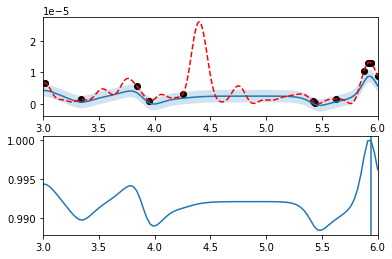

/Users/williamjenkins/miniconda3/envs/gp/lib/python3.9/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning:

Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.

/Users/williamjenkins/miniconda3/envs/gp/lib/python3.9/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning:

Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.



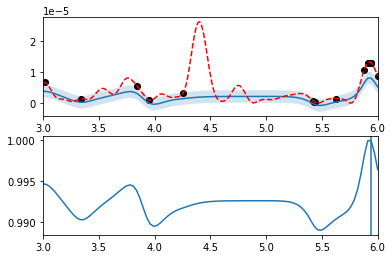

/Users/williamjenkins/miniconda3/envs/gp/lib/python3.9/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning:

Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.

/Users/williamjenkins/miniconda3/envs/gp/lib/python3.9/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning:

Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.



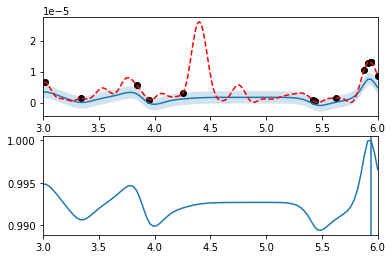

/Users/williamjenkins/miniconda3/envs/gp/lib/python3.9/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning:

Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.

/Users/williamjenkins/miniconda3/envs/gp/lib/python3.9/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning:

Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.



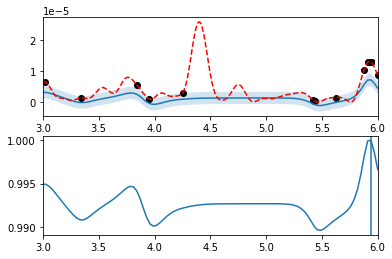

/Users/williamjenkins/miniconda3/envs/gp/lib/python3.9/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning:

Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.

/Users/williamjenkins/miniconda3/envs/gp/lib/python3.9/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning:

Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.



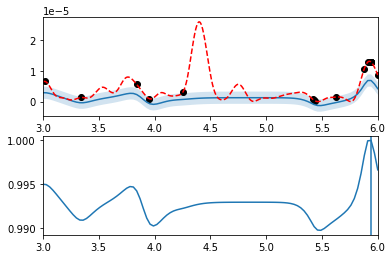

/Users/williamjenkins/miniconda3/envs/gp/lib/python3.9/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning:

Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.

/Users/williamjenkins/miniconda3/envs/gp/lib/python3.9/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning:

Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.



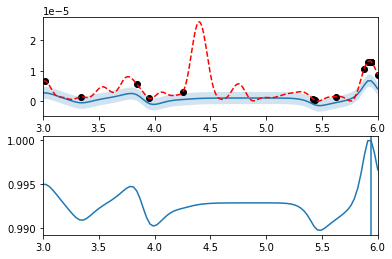

/Users/williamjenkins/miniconda3/envs/gp/lib/python3.9/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning:

Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.

/Users/williamjenkins/miniconda3/envs/gp/lib/python3.9/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning:

Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.



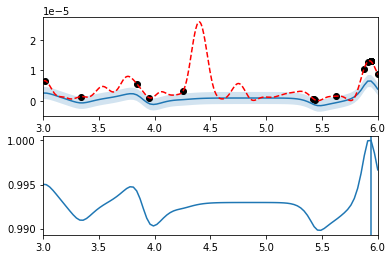

In [22]:
from botorch.acquisition import (
    ExpectedImprovement,
    UpperConfidenceBound,
    ProbabilityOfImprovement,
    qMaxValueEntropy
)
from botorch.fit import fit_gpytorch_model
from botorch.models import SingleTaskGP
from botorch.models.transforms import Normalize, Standardize
from botorch.utils.transforms import unnormalize
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double
torch.manual_seed(2009)

N_WARMUP = 10
N_ITER = 20

X_pred = torch.linspace(3., 6., 101)

def generate_random_samples(search_parameters, n=10):
    X = torch.zeros(n, len(search_parameters), device=device)
    for i, parameter in enumerate(search_parameters):
        m = torch.distributions.uniform.Uniform(torch.tensor(parameter["bounds"][0]), torch.tensor(parameter["bounds"][1]))
        X[:, i] = m.sample((n, 1)).squeeze()
    return X


def format_samples(search_parameters, x):
    searchparams = dict()
    for i, parameter in enumerate(search_parameters):
        searchparams[parameter["name"]] = x[i]
    return searchparams


def format_bounds(search_parameters):
    bounds = torch.zeros(2, len(search_parameters))
    for i, parameter in enumerate(search_parameters):
        bounds[:, i] = torch.tensor([parameter["bounds"][0], parameter["bounds"][1]])
    return bounds


def evaluate(parameters):
    p_rep = run_kraken(parameters)
    objective_raw = ambiguity_function(K, p_rep, atype="bartlett").item()
    return torch.tensor(objective_raw, dtype=dtype)


def evaluate_samples(fixedparams, search_parameters, X):
    objective = torch.zeros(X.size(0), 1)
    for i in range(X.size(0)):
        searchparams = format_samples(search_parameters, X[i])
        objective[i] = evaluate(fixedparams | searchparams)

    return objective


def best_observed_data(X, y):
    return X[torch.argmax(y)], torch.max(y)


def evaluate_acquisition_function(acq_func, X_pred):
    X_pred = X_pred[:, None, None]
    alpha = acq_func.forward(X_pred)
    new_X = X_pred[torch.argmax(alpha)]
    return new_X, alpha


def initialize_model(train_X, train_obj, state_dict=None):
    model = SingleTaskGP(
        train_X=train_X,
        train_Y=train_obj,
        input_transform=Normalize(d=train_X.shape[-1]),
        outcome_transform=Standardize(m=1)
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    if state_dict is not None:
        model.load_state_dict(state_dict)
        model.eval()
    return model, mll


bounds = format_bounds(parameters)

train_x = generate_random_samples(parameters, n=N_WARMUP)
train_obj = evaluate_samples(fixedparams, parameters, train_x)
_, best_obj = best_observed_data(train_x, train_obj)
best_obj = best_obj.detach().item()
# print(train_x.size(), train_obj.size())

train_x_UCB, train_x_PI, train_x_EI = train_x, train_x, train_x
train_obj_UCB, train_obj_PI, train_obj_EI = train_obj, train_obj, train_obj

# Initialize GP models
model_UCB, mll_UCB = initialize_model(train_x, train_obj)
model_PI, mll_PI = initialize_model(train_x, train_obj)
model_EI, mll_EI = initialize_model(train_x, train_obj)


best_observed_ucb, best_observed_pi, best_observed_ei = [], [], []
best_observed_ucb.append(best_obj)
best_observed_pi.append(best_obj)
best_observed_ei.append(best_obj)

for i in range(N_ITER - N_WARMUP):
    # Fit GP models
    fit_gpytorch_model(mll_UCB)
    fit_gpytorch_model(mll_PI)
    fit_gpytorch_model(mll_EI)
    
    # Evaluate acquisition functions & get new points.

    UCB = UpperConfidenceBound(model=model_UCB, beta=torch.tensor(0.01))
    new_X_UCB, alpha_UCB = evaluate_acquisition_function(UCB, X_pred)

    PI = ProbabilityOfImprovement(model=model_PI, best_f=best_observed_pi[-1])
    new_X_PI, alpha_PI = evaluate_acquisition_function(PI, X_pred)

    EI = ExpectedImprovement(model=model_EI, best_f=best_observed_ei[-1])
    new_X_EI, alpha_EI = evaluate_acquisition_function(EI, X_pred)

    candidate_EI, max_alpha_EI = optimize_acqf(
        EI,
        bounds=bounds,
        q=1,
        num_restarts=1,
        raw_samples=128
    )

    # Evaluate new sample
    new_obj_UCB = evaluate_samples(fixedparams, parameters, new_X_UCB)
    new_obj_PI = evaluate_samples(fixedparams, parameters, new_X_PI)
    new_obj_EI = evaluate_samples(fixedparams, parameters, new_X_EI)

    # Append to previous data
    train_x_UCB = torch.cat([train_x_UCB, new_X_UCB])
    train_x_PI = torch.cat([train_x_PI, new_X_PI])
    train_x_EI = torch.cat([train_x_EI, new_X_EI])
    
    train_obj_UCB = torch.cat([train_obj_UCB, new_obj_UCB])
    train_obj_PI = torch.cat([train_obj_PI, new_obj_PI])
    train_obj_EI = torch.cat([train_obj_EI, new_obj_EI])
    
    # Update progress
    best_observed_ucb.append(torch.max(train_obj_UCB))
    best_observed_pi.append(torch.max(train_obj_PI))
    best_observed_ei.append(torch.max(train_obj_EI))

    # Retrieve outputs for plotting:
    X_plot = X_pred.detach().numpy()
    x = train_x_EI.detach().numpy()
    y = train_obj_EI.detach().numpy()

    posterior = model_EI.posterior(X_pred[:, None])

    
    mu = posterior.mean.detach().numpy()
    sigma = posterior.variance.detach().numpy()
    confint_l = (mu - 2*sigma).squeeze()
    confint_u = (mu + 2*sigma).squeeze()
    
    fig = plt.figure(figsize=(6, 4))    
    # # Error
    plt.subplot(2, 1, 1)
    plt.fill_between(X_plot, confint_l, confint_u, alpha=0.2, label="$\mu\pm 2\sigma$")
    # # Mean
    plt.plot(X_plot, mu, label="$\mu$")
    # # Evaluations
    plt.scatter(x, y, c="k", label="Samples")
    # plt.scatter(x[-1], y[-1], c="r", marker="*", zorder=10)
    # # Truth
    plt.plot(rvec, B_bart[src_z_ind], "r--", label="True Obj")

    plt.xlim(X_plot.min(), X_plot.max())
    # plt.xlabel("Range [km]")
    # plt.ylabel("Bartlett Correlation")
    # plt.title(f"Sample {counter}")
    # plt.legend(loc="upper right")

    plt.subplot(2, 1, 2)
    plt.plot(X_plot, (alpha_EI / alpha_EI.max()).detach().numpy())
    plt.axvline(new_X_EI.detach().numpy())
    plt.xlim(X_plot.min(), X_plot.max())

    # fig.savefig(f"../../Reports/Figures/animation_TL/{counter:02d}.png", dpi=300, facecolor="white", bbox_inches="tight")
    # plt.close()
    plt.show()







    # Reinitialize the models
    model_UCB, mll_UCB = initialize_model(train_x_UCB, train_obj_UCB, model_UCB.state_dict())
    model_PI, mll_PI = initialize_model(train_x_PI, train_obj_PI, model_PI.state_dict())
    model_EI, mll_EI = initialize_model(train_x_EI, train_obj_EI, model_EI.state_dict())




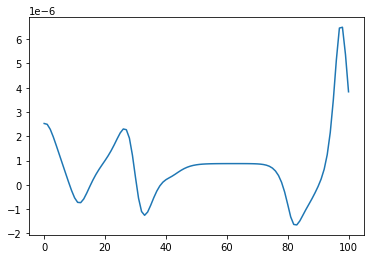

In [27]:
# plt.plot(alpha_EI.detach().numpy())
plt.plot(mu)

In [71]:
from copy import deepcopy

from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from ax.core.arm import Arm
from ax.core.observation import ObservationFeatures

# from ax.models.torch.botorch_modular.model import BoTorchModel
from ax.models.torch.botorch_modular.surrogate import Surrogate
# from ax.models.torch.botorch_modular.list_surrogate import ListSurrogate
# from ax.models.torch.botorch_modular.acquisition import Acquisition
# from ax.modelbridge.torch import TorchModelBridge
# from ax.modelbridge.registry import Cont_X_trans, Y_trans, Models
# from ax.service.utils.report_utils import exp_to_df
# from botorch.models.model import Model
from botorch.models.gp_regression import SingleTaskGP
from botorch.acquisition.analytic import ExpectedImprovement
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# obj_type = "bartlett"


# gpmodel = Models.BOTORCH_MODULAR
# GPEI_model = 

N_WARMUP = 5
NITER = 30

gs = GenerationStrategy(
    steps=[
        # 1. Initialization step (does not require pre-existing data and is well-suited for
        # initial sampling of the search space)
        GenerationStep(
            model=Models.SOBOL,
            num_trials=N_WARMUP,  # How many trials should be produced from this generation step
            min_trials_observed=3,  # How many trials need to be completed to move to next model
            max_parallelism=5,  # Max parallelism for this step
            model_kwargs={"seed": 2009},  # Any kwargs you want passed into the model
            model_gen_kwargs={},  # Any kwargs you want passed to `modelbridge.gen`
        ),
        # 2. Bayesian optimization step (requires data obtained from previous phase and learns
        # from all data available at the time of each new candidate generation call)
        # GenerationStep(
        #     model=Models.GPEI,
        #     num_trials=-1,  # No limitation on how many trials should be produced from this step
        #     max_parallelism=1,  # Parallelism limit for this step, often lower than for Sobol
        #     # More on parallelism vs. required samples in BayesOpt:
        #     # https://ax.dev/docs/bayesopt.html#tradeoff-between-parallelism-and-total-number-of-trials
        #     model_kwargs={"torch_device": device},
        # ),
        GenerationStep(
            model=Models.BOTORCH_MODULAR,
            num_trials=NITER - N_WARMUP,
            max_parallelism=1,
            model_kwargs={
                "torch_device": device,
                "surrogate": Surrogate(
                    botorch_model_class=SingleTaskGP,
                    mll_class=ExactMarginalLogLikelihood
                ),
                "botorch_acqf_class": qNoisyExpectedImprovement,
            }
        )
    ]
)

ax_client = AxClient(generation_strategy=gs, verbose_logging=False)
ax_client.create_experiment(
    name="test_kraken",
    parameters=parameters,
    objective_name="bartlett",
    # minimize=True,  # Optional, defaults to False.
    # parameter_constraints=["x1 + x2 <= 2.0"],  # Optional.
    # outcome_constraints=["bartlett_const >= 0.0"],  # Optional.
)


def evaluate(parameters):
    p_rep = run_kraken(parameters)
    objective_raw = ambiguity_function(K, p_rep, atype="bartlett").item()
    return {"bartlett": (objective_raw, 0.0)}


def plot_model(model):
    fig = plt.figure(figsize=(6, 4))
    plot_config = plot_slice(model, "rec_r", "bartlett").data["data"]

    x = plot_config[2]["x"]
    y = plot_config[2]["y"]
    # Error
    plt.fill_between(plot_config[0]["x"], plot_config[0]["y"], alpha=0.2, label="$\mu\pm 2\sigma$")
    # Mean
    plt.plot(plot_config[1]["x"], plot_config[1]["y"], label="$\mu$")
    # Evaluations
    plt.scatter(x, y, c="k", label="Samples")
    # Truth
    plt.plot(rvec, B_bart[src_z_ind], "r--", label="True Obj")

    plt.xlim(rvec.min(), rvec.max())
    plt.xlabel("Range [km]")
    plt.ylabel("Bartle Correlation")
    plt.title(fr"GP-approximated Ambiguity Surface")
    plt.legend(loc="upper right")
    return fig


pbar = tqdm(
    range(NITER),
    bar_format="{l_bar}{bar:20}{r_bar}{bar:-20b}",
    desc="BO",
    leave=True,
    position=0,
    unit="eval",
)

counter = 0
rvec_ = np.arange(rvec.min(), rvec.max(), 1001)
observation_features = [ObservationFeatures.from_arm(Arm(parameters={"rec_r": v})) for v in rvec]

for i in pbar:
    searchparams, trial_index = ax_client.get_next_trial()
    if i == 1:
        print(searchparams)

    ax_client.complete_trial(
        trial_index=trial_index, raw_data=evaluate(fixedparams | searchparams)
    )


    if i > 4:
        ax_client_copy = deepcopy(ax_client)
        model = ax_client_copy.generation_strategy.model
        # model = ax_client.generation_strategy.model

        counter += 1

        fig = plt.figure(figsize=(6, 4))
        plot_config = plot_slice(model, "rec_r", "bartlett").data["data"]
        x = plot_config[2]["x"]
        y = plot_config[2]["y"]
        # Error
        plt.subplot(2, 1, 1)
        plt.fill_between(plot_config[0]["x"], plot_config[0]["y"], alpha=0.2, label="$\mu\pm 2\sigma$")
        # Mean
        plt.plot(plot_config[1]["x"], plot_config[1]["y"], label="$\mu$")
        # Evaluations
        plt.scatter(x, y, c="k", label="Samples")
        plt.scatter(x[-1], y[-1], c="r", marker="*", zorder=10)
        # Truth
        plt.plot(rvec, B_bart[src_z_ind], "r--", label="True Obj")
        plt.xlim(rvec.min(), rvec.max())
        plt.xlabel("Range [km]")
        plt.ylabel("Bartlett Correlation")
        plt.title(f"Sample {counter}")
        plt.legend(loc="upper right")

        acqf_values = np.array(model.evaluate_acquisition_function(
            observation_features=observation_features
        ))
        acqf_values /= acqf_values.max()

        plt.subplot(2, 1, 2)
        plt.plot(rvec, acqf_values)
        plt.xlim(rvec.min(), rvec.max())

        fig.savefig(f"../../Reports/Figures/animation_TL/{counter:02d}.png", dpi=300, facecolor="white", bbox_inches="tight")
        plt.close()


    # best_trial, _, (best_obj, _) = ax_client.get_best_trial(use_model_predictions=False)
    # pbar.set_postfix(
    #     {"Best Trial": best_trial}
    #     | {k: v for k, v in searchparams.items()}
    #     | {"obj": best_obj["bartlett"]}
    # )


best_parameters, (means, covariances) = ax_client.get_best_parameters()
print(best_parameters)
# print(range_true, depth_true, bot_c_p_true, bot_rho_true)
# # print(means)

# render(ax_client.get_contour_plot())
# render(ax_client.get_optimization_trace())

[INFO 05-25 16:01:27] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='rec_r', parameter_type=FLOAT, range=[3.0, 6.0])], parameter_constraints=[]).
BO:  13%|██▋                 | 4/30 [00:00<00:01, 14.27eval/s]

{'rec_r': 3.651952645741403}


BO:  20%|████                | 6/30 [00:01<00:06,  3.68eval/s]/Users/williamjenkins/miniconda3/envs/gp/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

BO:  27%|█████▎              | 8/30 [00:02<00:09,  2.34eval/s]/Users/williamjenkins/miniconda3/envs/gp/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

BO:  30%|██████              | 9/30 [00:03<00:09,  2.11eval/s]/Users/williamjenkins/miniconda3/envs/gp/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

BO:  33%|██████▋             | 10/30 [00:03<00:10,  1.97eval/s]/Users/williamjenkins/miniconda3/envs/gp/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

BO:  37%|███████▎            | 11/30 [00:04<00:10,  1.81eval/s]

KeyboardInterrupt: 

In [70]:
search_param

NameError: name 'search_param' is not defined

Text(0.5, 1.0, 'Model Performance')

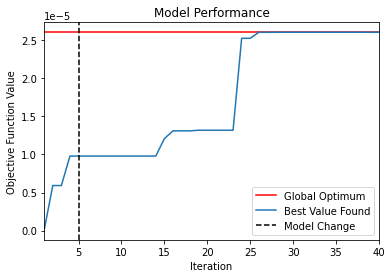

In [18]:
data = ax_client.get_optimization_trace().data["data"]
x = data[0]["x"]
y = data[0]["y"]
xv = data[3]["x"]
yv = data[3]["y"]

fig = plt.figure(figsize=(6,4))
plt.axhline(B_bart.max(), c="r", label="Global Optimum")
plt.plot(x, y, label="Best Value Found")
plt.axvline(xv[0], c="k", linestyle="--", label="Model Change")
plt.xlim(min(x), max(x))
plt.xlabel("Iteration")
plt.ylabel("Objective Function Value")
plt.legend()
plt.title("Model Performance")
# plt.savefig("../../Reports/Figures/perf_trace_1D.png", dpi=300, facecolor="white", bbox_inches="tight")

In [15]:
# ======================================================================
# ========================== FIXED PARAMETERS ==========================
# ======================================================================

# ---------------------- Miscellaneous Parameters ----------------------
fixedparams = dict()
fixedparams["title"] = "SWELLEX96"
fixedparams["tmpdir"] = "tmp"
fixedparams["model"] = "KRAKENC"

# --------------------------- Top Parameters ---------------------------
# None to configure.

# -------------------------- Layer Parameters --------------------------
fixedparams["layerdata"] = [
    {
        "z": z_data,
        "c_p": c_data,
        "rho": 1
    },
    {
        "z": [217, 240],
        "c_p": [1572.37, 1593.02],
        "rho": 1.8,
        "a_p": 0.3
    },
    {
        "z": [240, 1040],
        "c_p": [1881, 3245.8],
        "rho": 2.1,
        "a_p": 0.09
    }
]

# ------------------------- Bottom Parameters --------------------------
# Note: By default, bottom depth is pulled from layer data
fixedparams["bot_opt"] = "A"
fixedparams["bot_c_p"] = 5200.
fixedparams["bot_rho"] = 2.7
fixedparams["bot_a_p"] = 0.03

# ------------------------- Source Parameters --------------------------
fixedparams["src_z"] = depth_true

# ------------------------ Receiver Parameters ------------------------
fixedparams["rec_z"] = np.linspace(94.125, 212.25, 64)
# fixedparams["rec_r"] = range_true


# ------------------------ Freq/Mode Parameters ------------------------
fixedparams["freq"] = freq
fixedparams["clow"] = 0
fixedparams["chigh"] = 1600


# ======================================================================
# ============================ SEARCH SPACE ============================
# ======================================================================
parameters = [
    {
        "name": "rec_r",
        "type": "range",
        "bounds": [3., 6.],
        "value_type": "float"
    },
    {
        "name": "src_z",
        "type": "range",
        "bounds": [10., 100.],
        "value_type": "float"
    }
]

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# obj_type = "bartlett"

gs = GenerationStrategy(
    steps=[
        # 1. Initialization step (does not require pre-existing data and is well-suited for
        # initial sampling of the search space)
        GenerationStep(
            model=Models.SOBOL,
            num_trials=5,  # How many trials should be produced from this generation step
            min_trials_observed=3,  # How many trials need to be completed to move to next model
            max_parallelism=5,  # Max parallelism for this step
            model_kwargs={"seed": 999},  # Any kwargs you want passed into the model
            model_gen_kwargs={},  # Any kwargs you want passed to `modelbridge.gen`
        ),
        # 2. Bayesian optimization step (requires data obtained from previous phase and learns
        # from all data available at the time of each new candidate generation call)
        GenerationStep(
            model=Models.GPEI,
            num_trials=-1,  # No limitation on how many trials should be produced from this step
            max_parallelism=1,  # Parallelism limit for this step, often lower than for Sobol
            # More on parallelism vs. required samples in BayesOpt:
            # https://ax.dev/docs/bayesopt.html#tradeoff-between-parallelism-and-total-number-of-trials
            model_kwargs={"torch_device": device},
        ),
        # GenerationStep(
        #     model=Models.BO_MIXED,
        #     num_trials=-1,  # No limitation on how many trials should be produced from this step
        #     max_parallelism=1,  # Parallelism limit for this step, often lower than for Sobol
        #     # More on parallelism vs. required samples in BayesOpt:
        #     # https://ax.dev/docs/bayesopt.html#tradeoff-between-parallelism-and-total-number-of-trials
        #     model_kwargs={"torch_device": device}
        # ),
    ]
)

ax_client = AxClient(generation_strategy=gs, verbose_logging=False)
ax_client.create_experiment(
    name="test_kraken",
    parameters=parameters,
    objective_name="bartlett",
    # minimize=True,  # Optional, defaults to False.
    # parameter_constraints=["x1 + x2 <= 2.0"],  # Optional.
    # outcome_constraints=["bartlett_const >= 0.0"],  # Optional.
)


def evaluate(parameters):
    p_rep = run_kraken(parameters)
    objective_raw = ambiguity_function(K, p_rep, atype="bartlett").item()
    return {"bartlett": (objective_raw, 0.0)}


def plot_model(model):
    fig = plt.figure(figsize=(6, 4))
    plot_config = plot_slice(model, "rec_r", "bartlett").data["data"]

    x = plot_config[2]["x"]
    y = plot_config[2]["y"]
    # Error
    plt.fill_between(plot_config[0]["x"], plot_config[0]["y"], alpha=0.2, label="$\mu\pm 2\sigma$")
    # Mean
    plt.plot(plot_config[1]["x"], plot_config[1]["y"], label="$\mu$")
    # Evaluations
    plt.scatter(x, y, c="k", label="Samples")
    # Truth
    plt.plot(rvec, B_bart[src_z_ind], "r--", label="True Obj")

    plt.xlim(rvec.min(), rvec.max())
    plt.xlabel("Range [km]")
    plt.ylabel("Bartle Correlation")
    plt.title(fr"GP-approximated Ambiguity Surface")
    plt.legend(loc="upper right")
    return fig


NITER = 40
pbar = tqdm(
    range(NITER),
    bar_format="{l_bar}{bar:20}{r_bar}{bar:-20b}",
    desc="BO",
    leave=True,
    position=0,
    unit="eval",
)

counter = 0
for i in pbar:
    searchparams, trial_index = ax_client.get_next_trial()
    #     acqf_values = model.evaluate_acquisition_function(
    #         observation_features=ax_client._get_pending_observation_features(
    #             ax_client.generation_strategy.experiment
    #         )["bartlett"]
    #     )

    #     print(
    #         #         model.evaluate_acquisition_function(
    #         ax_client._get_pending_observation_features(
    #             ax_client.generation_strategy.experiment
    #         )["bartlett"]
    #         #         )
    #     )

    ax_client.complete_trial(
        trial_index=trial_index, raw_data=evaluate(fixedparams | searchparams)
    )


    # if i > 4:
    #     model = ax_client.generation_strategy.model
        
    #     counter += 1

    #     fig = plt.figure(figsize=(6, 4))
    #     plot_config = plot_slice(model, "rec_r", "bartlett").data["data"]
    #     x = plot_config[2]["x"]
    #     y = plot_config[2]["y"]
    #     # Error
    #     plt.fill_between(plot_config[0]["x"], plot_config[0]["y"], alpha=0.2, label="$\mu\pm 2\sigma$")
    #     # Mean
    #     plt.plot(plot_config[1]["x"], plot_config[1]["y"], label="$\mu$")
    #     # Evaluations
    #     plt.scatter(x, y, c="k", label="Samples")
    #     # Truth
    #     plt.plot(rvec, B_bart[src_z_ind], "r--", label="True Obj")
    #     plt.xlim(rvec.min(), rvec.max())
    #     plt.xlabel("Range [km]")
    #     plt.ylabel("Bartle Correlation")
    #     plt.title(f"Sample {counter}")
    #     plt.legend(loc="upper right")
    #     fig.savefig(f"../../Reports/Figures/animation_TL/{counter:02d}.png", dpi=300, facecolor="white", bbox_inches="tight")
    #     plt.close()

    best_trial, _, (best_obj, _) = ax_client.get_best_trial(use_model_predictions=False)
    pbar.set_postfix(
        {"Best Trial": best_trial}
        | {k: v for k, v in searchparams.items()}
        | {"obj": best_obj["bartlett"]}
    )


best_parameters, (means, covariances) = ax_client.get_best_parameters()
print(best_parameters)
print(range_true, depth_true)
# print(means)

[INFO 05-12 11:52:16] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='rec_r', parameter_type=FLOAT, range=[3.0, 6.0]), RangeParameter(name='src_z', parameter_type=FLOAT, range=[10.0, 100.0])], parameter_constraints=[]).
BO: 100%|████████████████████| 40/40 [00:21<00:00,  1.86eval/s, Best Trial=19, rec_r=5.92, src_z=19.1, obj=2.6e-5]


{'rec_r': 4.400384113603717, 'src_z': 54.06984649085438}
4.4 54


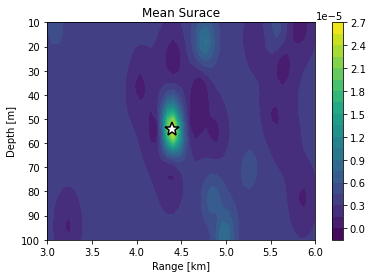

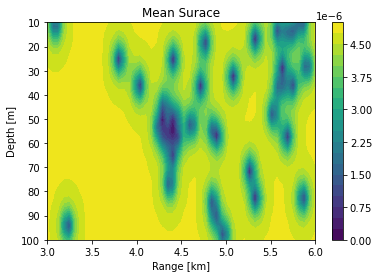

In [17]:
import plotly.graph_objects as go

plt.figure(figsize=(6, 4))
x = np.array(ax_client.get_contour_plot().data["data"][0]["x"])
y = np.array(ax_client.get_contour_plot().data["data"][0]["y"])
Z = np.array(ax_client.get_contour_plot().data["data"][0]["z"])
X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, Z, 20)
plt.plot(best_parameters["rec_r"], best_parameters["src_z"], 'w*', markersize=15, markeredgewidth=1.5, markeredgecolor="k")
plt.gca().invert_yaxis()
cbar = plt.colorbar()
plt.xlabel("Range [km]")
plt.ylabel("Depth [m]")
plt.title("Mean Surace")
plt.savefig("../../Reports/Figures/GP_2D_Sim_Mean.png", facecolor="white", bbox_inches="tight", dpi=300)
plt.show()


plt.figure(figsize=(6, 4))
x = np.array(ax_client.get_contour_plot().data["data"][1]["x"])
y = np.array(ax_client.get_contour_plot().data["data"][1]["y"])
Z = np.array(ax_client.get_contour_plot().data["data"][1]["z"])
X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, Z, 20)
plt.gca().invert_yaxis()
cbar = plt.colorbar()
plt.xlabel("Range [km]")
plt.ylabel("Depth [m]")
plt.title("Mean Surace")
plt.savefig("../../Reports/Figures/GP_2D_Sim_SE.png", facecolor="white", bbox_inches="tight", dpi=300)
plt.show()

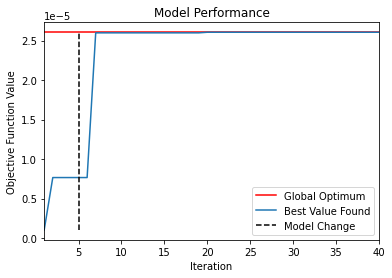

In [18]:
data = ax_client.get_optimization_trace().data["data"]
x = data[0]["x"]
y = data[0]["y"]
xv = data[3]["x"]
yv = data[3]["y"]

fig = plt.figure(figsize=(6,4))
plt.axhline(B_bart.max(), c="r", label="Global Optimum")
plt.plot(x, y, label="Best Value Found")
plt.plot(xv, yv, "k--", label="Model Change")
plt.xlim(min(x), max(x))
plt.xlabel("Iteration")
plt.ylabel("Objective Function Value")
plt.legend()
plt.title("Model Performance")
plt.savefig("../../Reports/Figures/perf_trace_2D.png", dpi=300, facecolor="white", bbox_inches="tight")

In [19]:
B_bart.max()

2.6048110592448504e-05

In [47]:
test = np.arange(3, 6, 0.5).reshape(1, -1)

array([[3. , 3.5, 4. , 4.5, 5. , 5.5]])

In [69]:
[Arm(parameters={"rec_r": v}) for v in np.arange(3, 6, 0.5)]

[Arm(parameters={'rec_r': 3.0}),
 Arm(parameters={'rec_r': 3.5}),
 Arm(parameters={'rec_r': 4.0}),
 Arm(parameters={'rec_r': 4.5}),
 Arm(parameters={'rec_r': 5.0}),
 Arm(parameters={'rec_r': 5.5})]

In [68]:
ax_client.experiment.arms_by_name.values()

dict_values([Arm(name='0_0', parameters={'rec_r': 4.8861894607543945}), Arm(name='1_0', parameters={'rec_r': 3.8336969213560224}), Arm(name='2_0', parameters={'rec_r': 3.2944608544930816}), Arm(name='3_0', parameters={'rec_r': 5.987575443461537}), Arm(name='4_0', parameters={'rec_r': 5.561629551462829}), Arm(name='5_0', parameters={'rec_r': 4.237398973018873}), Arm(name='6_0', parameters={'rec_r': 3.0}), Arm(name='7_0', parameters={'rec_r': 6.0}), Arm(name='8_0', parameters={'rec_r': 5.849454670440311}), Arm(name='9_0', parameters={'rec_r': 5.947946790792236})])